In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import plotly.graph_objects as go

In [2]:
from src.datasets.datamodules import DataModule
from src.my_model.transformer import *

In [3]:
# Instantiate the DataModule num_workers=16)
dataset_wrapper = DataModule(dataset_type="tml", dataset_dir="Data/Tml")

dataset_wrapper.setup()
tl = dataset_wrapper.test_dataloader()

─────────────────────────────────────────────────── Tml Dataset ───────────────────────────────────────────────────

Loading data from Data/Tml/preprocessed_train.pt

/home/couthures/Bureau/TrackParameters/TrackFormer/src/datasets/datamodules.py:289: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.datalist = torch.load(self.data_file)


Loading data from Data/Tml/preprocessed_val.pt

Loading data from Data/Tml/preprocessed_test.pt

In [4]:
# Load models
mse_trans_tml = "Data/lightning_logs/tml-1/checkpoints/model-epoch=3940-val_loss=251.23.ckpt"
qloss_tml_trasf = "Data/Tb_tml/model-epoch=8193-val_loss=2.68.ckpt"
 
# _instantiator is a function that is called to instantiate the model
# Here the models have been trained using cli raising an error if _instantiator is not None
transf_mse_model = TrackFormer.load_from_checkpoint(checkpoint_path=mse_trans_tml, _instantiator=None)
transf_mse_model.eval().to("cpu")

qloss_transf_tt_model = TrackFormer.load_from_checkpoint(checkpoint_path=qloss_tml_trasf, _instantiator=None)
qloss_transf_tt_model.eval().to("cpu")

bad_tracks_q = []
bad_tracks_mse = []

relative_errors_mse = []
relative_errors_qloss = []

errors_mse = []
errors_qloss = []


with torch.no_grad():
    for i, (input, mask, target) in enumerate(tqdm(tl)):
        
        # Transformers
        pt_pred_mse = transf_mse_model(input)[:, 0]
        pt_pred_qloss = qloss_transf_tt_model(input)[:, 0]
        pt_true = target[:, 0]

        error_mse = abs(pt_true - pt_pred_mse)
        error_qloss = abs(pt_true - pt_pred_qloss)

        errors_mse.extend(error_mse.tolist())

        relative_error_mse = error_mse / pt_true
        relative_error_qloss = error_qloss / pt_true

        if (relative_error_mse > 10).any():
            mask_ = relative_error_mse > 10
            selected = input[mask_][0]
            
            
            error_values = error_mse[mask_].tolist()
            pt_values = pt_true[mask_].tolist()
            bad_tracks_mse.extend(((error, pt), selected) for error, pt in zip(error_values, pt_values))

        if (relative_error_qloss > 10).any():
            mask_ = relative_error_qloss > 10
            selected = input[mask_][0]
            
            error_values = error_qloss[mask_].tolist()
            pt_values = pt_true[mask_].tolist()
            bad_tracks_q.extend(((error, pt), selected) for error, pt in zip(error_values, pt_values))

        relative_errors_mse.extend(relative_error_mse.tolist())
        relative_errors_qloss.extend(relative_error_qloss.tolist())



"criterion":     mse
"dropout":       0.1
"input_dim":     3
"input_dropout": 0.1
"lr":            0.0002
"model_dim":     128
"num_classes":   2
"num_heads":     4
"num_layers":    2
"use_scheduler": True
"warmup":        100
"criterion":     qloss-0.2
"dropout":       0.0
"input_dim":     3
"input_dropout": 0.0
"lr":            0.0005
"model_dim":     128
"num_classes":   2
"num_heads":     4
"num_layers":    2
"use_scheduler": False
"warmup":        100


  0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
def view_trajectory(inputs, mask=None):
    """
    Plots the trajectory of a particle in 3D.
    """
    
    if mask is None:
            # Filter out zero rows
            inputs = inputs[(inputs != 0).any(dim=1)]

    else:
        inputs = inputs[mask]

    x = inputs[:, 0].numpy()
    y = inputs[:, 1].numpy()
    z = inputs[:, 2].numpy()

    fig = go.Figure(data=[go.Scatter3d(
        x=x, y=y, z=z,
        mode='lines+markers',
        marker=dict(size=4, color='blue', opacity=0.8),
        line=dict(color='blue', width=2)
    )])

    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title='Particle Trajectory'
    )

    fig.show()


In [6]:
i = 5
view_trajectory(bad_tracks_q[i][1])

In [7]:
thing = bad_tracks_q[i][1][(bad_tracks_q[i][1] != 0).any(dim=1)][:,:2]

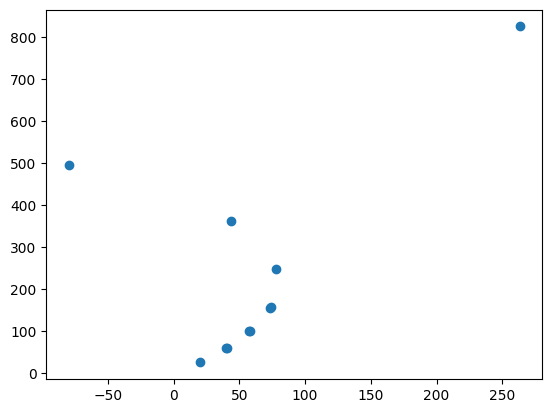

In [8]:
plt.scatter(thing[:,0],thing[:,1])

In [9]:
from src.my_model.benchmarks import CircleFit



cf = CircleFit()


# f"circle pred: {cf.fit(thing.unsqueeze(0)).item():.2f} \t true{}"
f"circle pred: {cf.fit(thing.unsqueeze(0)).item():.2f} \t true"

/home/couthures/Bureau/TrackParameters/TrackFormer/src/my_model/benchmarks.py:51: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)



'circle pred: 11113159.02 \t true'

In [10]:
bad_tracks_q[i][0][1]

0.2052895724773407

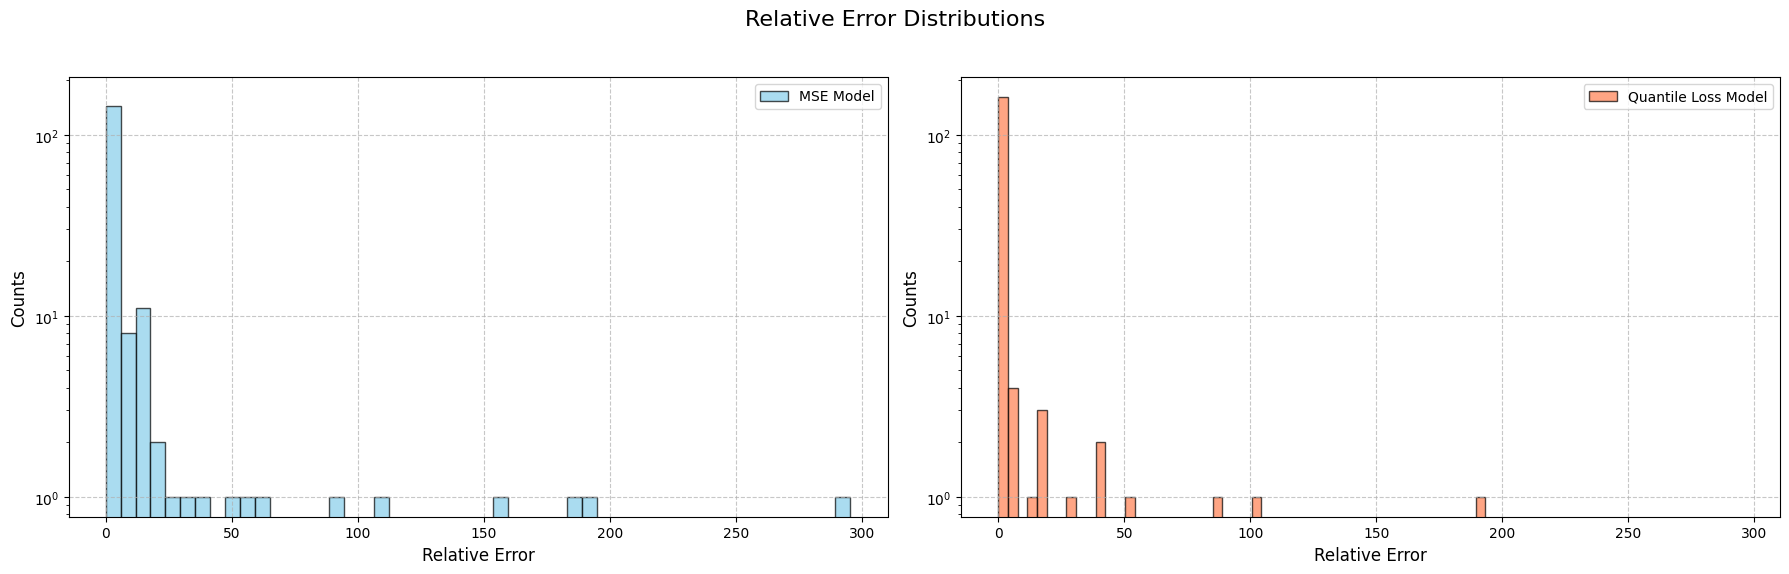

In [11]:
plt.figure(figsize=(18, 6))
plt.suptitle('Relative Error Distributions', fontsize=16)

# MSE Model
plt.subplot(1, 2, 1)
plt.hist(relative_errors_mse, bins=50, alpha=0.7, label='MSE Model', color='skyblue', edgecolor='black')
plt.xlabel('Relative Error', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Qloss
plt.subplot(1, 2, 2)
plt.hist(relative_errors_qloss, bins=50, alpha=0.7, label='Quantile Loss Model', color='coral', edgecolor='black')
plt.xlabel('Relative Error', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# Use the same axis limits for both plots
left, right = None, None
bottom, top = None, None

for i in range(1, 3):
    plt.subplot(1, 2, i)
    left_, right_ = plt.xlim()
    bottom_, top_ = plt.ylim()

    if left is None or left_ < left:
        left = left_
    if right is None or right_ > right:
        right = right_
    if bottom is None or bottom_ < bottom:
        bottom = bottom_
    if top is None or top_ > top:
        top = top_

# Apply the same limits to the subplots
for i in range(1, 3):
    plt.subplot(1, 2, i)
    plt.xlim(left, right)
    plt.ylim(bottom, top)


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('relative_error_distributions.png', format='png')
plt.show()

In [12]:
bad_tracks_q[i][0]

(3.2063097953796387, 0.20282889902591705)